In [96]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from math import factorial
import sympy as sp
sp.init_printing()
import pandas as pd
import urllib.request

# Actividad 05: Interpolación

---
### Profesor: Juan Marcos Marín
### Nombre: Martín Calvo Domínguez
*Métodos computacionales 2025-I*

---

In [97]:
#@title Funciones
def interplineal(x,y):
  """
  x:tupla, valores de x inicial y final
  y:tupla, valores de y inicial y final
  x, y deben tener el mismo tamaño
  devuelve la función de la recta entre los dos puntos
  """
  if len(x)!= len(y):
    raise ValueError("los arrays deben tener el mimso tamaño")
  def funcion(xinterp):
    """
    recibe un valor x deseado y lo evalúa en la recta interpolada
    DEBE ESTAR DENTRO DEL INTERVALO
    """

    return (xinterp-x[0])*((y[0]-y[-1])/(x[0]-x[-1])) + y[0] #y=mx+b
  return funcion
#-------------------------------------------------------------------------------------------
def interplagrange(x,y):
  """
  x:array de coordenadas x de los puntos
  y: array de coordenadas y de los puntos
  Devuelve una función de un polinomio de un grado menor a la cantidad de puntos
  """
  def sumatoria(xinterp):

    L=np.zeros_like(x)
    suma=0

    for i in range(0,len(x)):
      producto=1
      for j in range(0, len(x)):
        if i!=j:
          producto*=(xinterp-x[j])/(x[i]-x[j])
      suma+= y[i]*producto
    return suma
  return sumatoria

#-------------------------------------------------------------------------------------------

def diferencias_divididas(x,y,i,j):
  if i==j:
    return y[i]
  else:
    num=diferencias_divididas(x,y,i+1,j)-diferencias_divididas(x,y,i,j-1)  #La función va cogiendo de a pares entonces se construye reiterando los pares hasta que se cumpla la primera condición
    den= x[j]-x[i]
    return num/den
def interpnewton(x,y):
  """
  x:array de coordenadas x de los puntos
  y:array de coordenadas y de los puntos
  Devuelve una función, polinomio de Newton
  """

  def funcion(xinterp):
    producto=1
    suma=y[0]
    for i in range(1,len(x)):

      a=diferencias_divididas(x,y,0,i)
      producto*=(xinterp-x[i-1])
      suma+=a*producto
    return suma
  return funcion

#-------------------------------------------------------------------------------------------------

def baseslagrange(x,i):
  """
  x:array de las coordenadas x de los puntos
  i: es la iteración en la que está
  Devuelve la función h(x), base de lagrange
  """
  def funcion(xinterp):
    producto=1

    for j in range(len(x)):

      if i!=j:
        producto*=(xinterp-x[j])/(x[i]-x[j])
    return producto
  return funcion

def interphermite(x,y,dy):
  """
  x: array con las coordenadas x de los puntos
  y: array con las coordenadas y de los puntos
  dy: array con el valor de la derivada en cada punto
  Devuelve un polinomio de grado 2n+1, siendo n+1 el número de puntos
  """

  def funcion(equis):
    suma=0
    z=sp.symbols("z")
    for i in range(len(x)):
      h=baseslagrange(x,i)
      hprima=sp.lambdify(z,sp.diff(h(z),z))
      A=(h(equis)**2)*((1-2*(equis-x[i])*hprima(x[i])))
      B=(h(equis)**2)*(equis-x[i])
      suma+=A*y[i]+B*dy[i]
    return suma
  return funcion
#-------------------------------------------------------------------------------------------



# 1
Supongamos que queremos interpolar la función  $f(x)=\sin(x)$  usando los puntos  $x_0=0$ ,  $x_1=\pi/2$ , y  $x_2=\pi$.

Encuentre el polinomio de interpolación de Lagrange y el error asociado al misma. Recuerde que el error de interpolación de Lagrange puede expresarse explícitamente como:

\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation}

Donde:
- $f^{(n+1)}(\xi)$ es la derivada de orden $n$ de la función $f(x)$ evaluada en algún punto $\xi$ en el intervalo de interpolación.

- Repita el numeral anterior, pero para los polinomios de interpolación de Hermite, conociendo que:


$$
f(x) - P(x) = \epsilon = \frac{f^{(2n+2)}(\xi)}{(2n+2)!} \prod_{i=0}^{n} (x - x_i)^2
$$

*Nota: recuerde que los indices en python inician en 0, luego si tenemos $n+1$ datos el polinomio es de orden $n$*

In [98]:
x=np.array([0, np.pi/2, np.pi])
y=np.sin(x)
dy=np.cos(x)

Polinomio_Lagrange=interplagrange(x,y) #Este es el polinomio, el procedimiento de cómo se obtuvo está en el apartado de funciones
Polinomio_Hermite=interphermite(x,y,dy)

x=sp.symbols("x")
Lagrange_expandido=sp.expand(Polinomio_Lagrange(x)) #Se expande para que quede en menos términos, más legible y elegante
Hermite_expandido=sp.expand(Polinomio_Hermite(x))


def errorlagrange(x,f):
  """
  x: array de las coordenadas x de los puntos
  f: función original, en sympy
  Devuelve una función que calcula el error para cualquier punto x
  """
  a=min(x)
  b=max(x)
  intervalo=np.linspace(a,b,100)
  e=sp.symbols("e")
  fun=f(e)


  productoria=np.zeros_like(intervalo)
  for j in range(len(intervalo)):
    producto=1
    for i in range(len(x)):
      producto*=(intervalo[j]-x[i])
    productoria[j]=abs(producto)
  producto=max(productoria)

  nmas1=len(x)  #n+1 es la cantidad de puntos que hay

  dnf=sp.diff(fun,e,nmas1)
  y=np.zeros_like(x)
  for i in range(len(x)):
    y[i]=dnf.subs(e,x[i])
  for i in x:
    if dnf.subs(e,i)==max(y):  #esta es la condición que hace que coja el error mayor posible
      xi=i
  return producto*(dnf.subs(e,xi)/factorial(nmas1))


def errorhermite(x,f):
  """
  x: array de las coordenadas x de los puntos
  f: función original, en sympy
  Encuentra el error máximo en un el intervalo que da [xmin,xmax], esto cogiendo un linspace con 100 valores, y evaluado para encontrar el mayor
  """
  a=min(x)
  b=max(x)
  intervalo=np.linspace(a,b,100)
  e=sp.symbols("e")
  fun=f(e)

  productoria=np.zeros_like(intervalo)
  for j in range(len(intervalo)):
    producto=1
    for i in range(len(x)):
      producto*=(intervalo[j]-x[i])**2
    productoria[j]=abs(producto)
  producto=max(productoria)
  nmas1=len(x)
  dosnmas2=2*len(x)

  dnf=sp.diff(fun,e,dosnmas2)
  y=np.zeros_like(x)
  for i in range(len(x)):
    y[i]=abs(dnf.subs(e,x[i]))
  for i in x:
    if abs(round(dnf.subs(e,i),6))==abs(round(max(y),6)):
      xi=i
  return abs(producto*(dnf.subs(e,xi)/factorial(dosnmas2)))



In [99]:
x=np.array([0, np.pi/2, np.pi])
y=np.sin(x)
dy=np.cos(x)

Polinomio_Lagrange=interplagrange(x,y) #Este es el polinomio, el procedimiento de cómo se obtuvo está en el apartado de funciones

var=sp.symbols("x")
Lagrange_expandido=sp.expand(Polinomio_Lagrange(var)) #Se expande para que quede en menos términos, más legible y elegante

print(f"Usando Lagrange, sin(pi/6)≈{Lagrange_expandido.subs(var,np.pi/6):.4f}")
print(f"El error máximo acotado es {errorlagrange(x,sp.sin):.4f}")
print(f"El valor real de sin(pi/6) es {np.sin(np.pi/6):.4f}")
Lagrange_expandido #polinomio de lagrange

Usando Lagrange, sin(pi/6)≈0.5556
El error máximo acotado es 0.2486
El valor real de sin(pi/6) es 0.5000


                     2                     
- 0.405284734569351⋅x  + 1.27323954473516⋅x

In [100]:
x=np.array([0, np.pi/2, np.pi])
y=np.sin(x)
dy=np.cos(x)

Polinomio_Hermite=interphermite(x,y,dy)

var=sp.symbols("x")
Hermite_expandido=sp.expand(Polinomio_Hermite(var))

print(f"Usando Hermite, sin(pi/6)≈{Hermite_expandido.subs(var,np.pi/6):.4f}")
print(f"El error máximo acotado es {errorhermite(x,sp.sin):.4f}")
print(f"El valor real de sin(pi/6) es {np.sin(np.pi/6):.5f}")
Hermite_expandido #polinomio de hermite

Usando Hermite, sin(pi/6)≈0.5026
El error máximo acotado es 0.0031
El valor real de sin(pi/6) es 0.50000


                      5                       4                      3         ↪
7.28583859910259e-16⋅x  + 0.0352495783421457⋅x  - 0.221479632723667⋅x  + 0.029 ↪

↪                2        
↪ 5895073584397⋅x  + 1.0⋅x

# 2

En física nuclear se calcula la sección eficaz de dispersión (scattering cross section) a partir de experimentos de colisiones, se sabe a partir de la teoría que la sección eficaz se describe por la formula de Breit-Wigner,

$$\sigma(E)=\frac{\sigma_0}{(E-E_r)^2+\frac{\Gamma^2}{4}}$$

donde $E$ es la energía y $E_r,\sigma_0, \Gamma$ son parámetros a ajustar; el valor predicho es $(E_r,\Gamma) = (78, 55)$ MeV; donde $\sigma_0$ se puede calcular ahora a partir de la fórmula simplemente remplazando cualquier par de puntos de la tabla.

A partir de los valores de energía,


```
Energia  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma_exp= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])

```

* Calcule los polinomios de Lagrange, Newton y Hermite.

* Haga un gráfico de los polinomios junto con la función original.

* Finalmente, a partir de la diferencia $|f(x) - P_n(x)|$ calcule el máximo   error asociado a cada uno de ellos. ¿Cuál será el mejor?

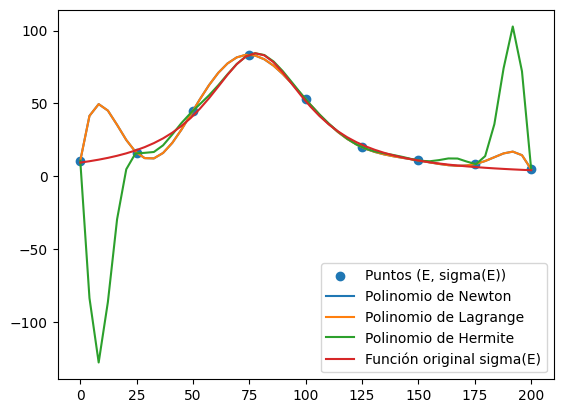

In [101]:
E  = np.array([0   , 25  , 50  , 75  , 100 , 125 , 150 , 175 , 200])
sigma= np.array([10.6, 16.0, 45.0, 83.5, 52.8, 19.9, 10.8, 8.25, 4.7])
e=sp.symbols("E")
Er=78
T=55
sigma_0=sigma[3]*((((E[3]-Er)**2) +(T**2)/4))
f=lambda e:(sigma_0)/(((e-Er)**2) +(T**2)/4)
s=sp.diff(f(e))
ds=sp.lambdify(e,s)
x=np.linspace(0,1000)

Pnewton=interpnewton(E,sigma)
Plagrange=interplagrange(E,sigma)
Phermite=interphermite(E,sigma,ds(E))

plt.scatter(E,sigma, label="Puntos (E, sigma(E))")
x=np.linspace(0,200)

plt.plot(x,Pnewton(x), label="Polinomio de Newton")
plt.plot(x,Plagrange(x), label="Polinomio de Lagrange")
plt.plot(x,Phermite(x), label="Polinomio de Hermite")
plt.plot(x,f(x), label="Función original sigma(E)")
plt.legend()

In [102]:
ErrorN=np.zeros_like(x, float)
ErrorL=np.zeros_like(x,float)
ErrorH=np.zeros_like(x, float)

for i in range(len(x)):
  ErrorN[i]=f(x[i])-Pnewton(x[i])
  ErrorL[i]=f(x[i])-Plagrange(x[i])
  ErrorH[i]=f(x[i])-Phermite(x[i])
print(max(ErrorN))
print(max(ErrorL))
print(max(ErrorH))

10.492881484970404
10.492881484970383
139.37456247902497


# 3
Consideremos la función:
\begin{equation*}
     f(x) = \frac{1}{1+25x^2}
\end{equation*}
en el intervalo $[-1, 1]$, definamos un conjunto de puntos $n+1$  equiespaciados en $[-1,1]$.

* Representar gráficamente la función junto al polinomio de interpolación de Lagrange, $p_n(x)$, para $n=\{ 4, 8, 12, 16, 20 \}$.
* Comprobar gráficamente cómo el error aumenta con $n$. Emplee la libreria, simbolica de `sympy` y encuente el error en la interpolación. La cota del  error , viene dado por:
\begin{equation}
f(x) - P(x) = \epsilon = \frac{1}{(n+1)!} f^{(n+1)}(\xi)(x - x_0)(x - x_1) ... (x - x_n)
\end{equation},

emplee la libreria simbólica para realizar la estimación de dicha cuota, sólo para $n = 4$, en el punto $x=0.5$.

* Repita la parte inicial para el conjunto de $p_n(x)$ con $n=\{ 4, 8, 12, 16, 20 \}$, usando la interpolación de Hermite, ¿existe alguna diferencia?

* Usando los datos del numeral anterior ahora usando el método `CubicSpline` realiza la interpolación y concluya.

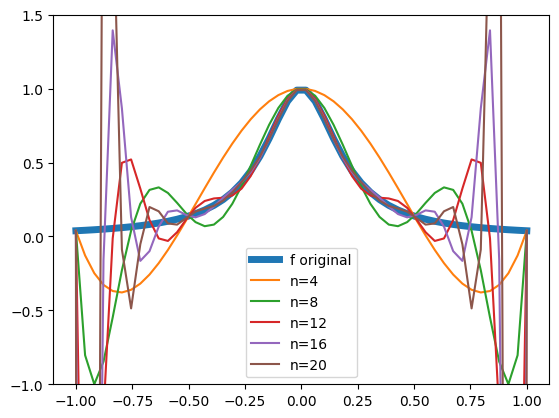

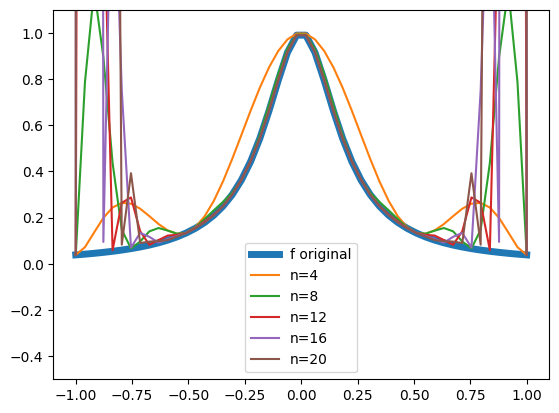

In [103]:
f=lambda x:1/(1+25*(x**2))
t=sp.symbols("x")
efe=f(t)
df=sp.lambdify(t,sp.diff(efe,t))

intervalo=lambda n:np.linspace(-1,1,n+1)
x=np.linspace(-1,1)

n=[4,8,12,16,20]

plt.plot(x,f(x),linewidth=5,label="f original")
for i in n:
  plt.plot(x,interplagrange(intervalo(i),f(intervalo(i)))(x),label=f"n={i}")
  plt.ylim(-1,1.5)
  plt.legend()
plt.show()


plt.plot(x,f(x),linewidth=5,label="f original")
for i in n:
  plt.plot(x,interphermite(intervalo(i),f(intervalo(i)),df(intervalo(i)))(x),label=f"n={i}")
  plt.ylim(-0.5,1.1)

  plt.legend() #Estoy casi seguro de que tengo algo mal en la función de Hermite porque debería ser la más exacta

# 4

Consideremos la imagen ![paloma](https://github.com/hernansalinas/autogrades/blob/main/Laboratorios_Taller/img/paloma.png?raw=true).

Ref: Metodos numericos, Burden.


Con los datos dados en la tabla:

1. Representar gráficamente la imagen, usando las órdenes `imread` e `imshow` de python (estas órdenes están contenidas en el paquete `matplotlib`)

2. Definir una lista de puntos, $x_i$,$y_i$ del pato y realice una interpolación lineal entre los mismos.

3. Representar el polinomio de interpolación de Lagrange en estos puntos, para aproximar el dibujo.

4. Repetir el proceso de interpolación mediante *splines* cúbicos. Para ello, utilizar la función `CubicSpline` (contenida en `scipy.interpolate`),


5. Comparar los resultados. ¿Alguna de las interpolaciones presenta oscilaciones? ¿A qué se debe este fenómeno?

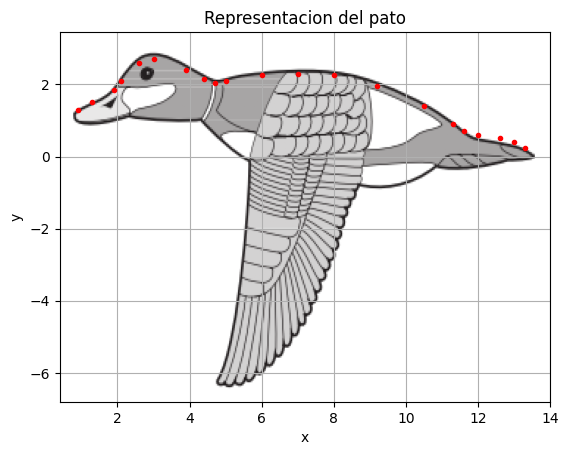

In [105]:
pato = 'https://3.bp.blogspot.com/-8_LTrCIxVSQ/VxU-5Gq2ffI/AAAAAAAAIto/LhCDEwHKTiAbLr7IhizQwGV13YTwgpbDwCLcB/s400/pato1.png' #URL
urllib.request.urlretrieve(pato, 'pato.jpg')# Decargar la imagen
imagen_pato = plt.imread('pato.jpg') # Variable con la imagen del pato

# Definimos los puntos del pato
xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

# Representamos graficamente al pato y los puntos que definimos para su contorno superior
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45)) # Ajustamos los pixeles para que coincidan con x e y
plt.plot(xp, yp, '.r')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


La interpolación de Lagrange presenta oscilaciones, esto es porque este método de interpolación funciona mejor para menos puntos, ya que solo garantiza un polinomio que pase por todos ellos, no responde por las oscilaciones entre puntos


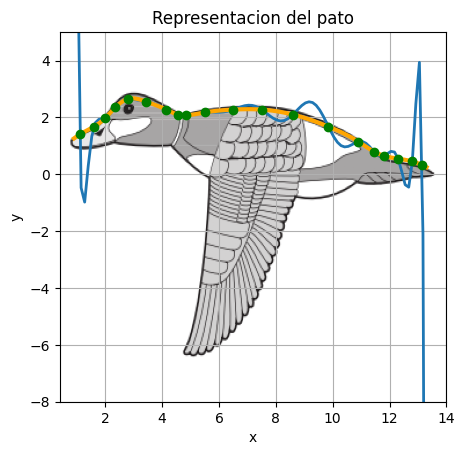

In [106]:
#lineal=interplineal(xp,yp)
plt.figure()
plt.title('Representacion del pato')
plt.imshow(imagen_pato, extent = (0.4, 14, -6.8, 3.45))

plt.xlabel('x')
plt.ylabel('y')
plt.grid()



xp = [0.9, 1.3, 1.9, 2.1, 2.6, 3.0, 3.9, 4.4, 4.7, 5.0, 6.0, 7.0, 8.0, 9.2, 10.5, 11.3, 11.6, 12.0, 12.6, 13.0, 13.3]
yp = [1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25]

listax=[]
listay=[]
for i in range(1, len(xp)):
  recta=interplineal((xp[i-1],xp[i]), (yp[i-1],yp[i]))
  listax.append(xp[i]-(xp[i]-xp[i-1])/2) #un punto intermedio entre los dos
  listay.append(recta(xp[i]-(xp[i]-xp[i-1])/2)) #hice un nuevo set de puntos x,y usando interpolaciuón lineal, de forma que los nuevos puntos son el punto medio entre cada par de puntos anteriores

Plagrange=interplagrange(listax,listay)
Psplines=CubicSpline(listax,listay)
x=np.linspace(min(xp), max(xp),100)

plt.plot(x,Plagrange(x), linewidth=2)
plt.ylim(-8,5)
plt.plot(x,Psplines(x),linewidth=3, color="orange")
plt.plot()
plt.plot(listax,listay,"o",color="g")
print("La interpolación de Lagrange presenta oscilaciones, esto es porque este método de interpolación funciona mejor para menos puntos, ya que solo garantiza un polinomio que pase por todos ellos, no responde por las oscilaciones entre puntos")

# 5

Calcular el spline cúbico que interpola los puntos $(-1,5)$, $(0,3)$, $(1,3)$, $(2,4)$, para esto escriba la matriz asociada y encuentre los polinomios $S_0(x)$, $S_1(x)$ y $S_2(x)$. Evalue su respuesta para $x= 1.5$ usando `CubicSpline` de `scipy`.

In [ ]:
x=[-1,0,1,2]
y=[5,3,3,4]

a0=sp.symbols("a0")
a1=sp.symbols("a1")
a2=sp.symbols("a2")
b0=sp.symbols("b0")
b1=sp.symbols("b1")  #Definiendo todas las variables simbólicas
b2=sp.symbols("b2")
c0=sp.symbols("c0")
c1=sp.symbols("c1")
c2=sp.symbols("c2")
d0=sp.symbols("d0")
d1=sp.symbols("d1")
d2=sp.symbols("d2")
xsym=sp.symbols("x")

def S(a, b, c, d, x, xi):
    return a + b*(x - xi) + c*(x - xi)**2 + d*(x - xi)**3

def Sprima(b, c, d, x, xi):
    return b + 2*c*(x - xi) + 3*d*(x - xi)**2

def S2prima(c, d, x, xi):
    return 2*c + 6*d*(x - xi)

S0=S(a0,b0,c0,d0,xsym,x[0])
S1=S(a1,b1,c1,d1,xsym,x[1])
S2=S(a2,b2,c2,d2,xsym,x[2])
S3=S(a2,b2,c2,d2,xsym,x[2])

Sprima0=Sprima(b0,c0,d0,xsym,x[0])
Sprima1=Sprima(b1,c1,d1,xsym,x[1])  #las funciones S, S' y S'' para los índices 0,1, y 2
Sprima2=Sprima(b2,c1,d2,xsym,x[2])

S2prima0=S2prima(c0,d0,xsym,x[0])
S2prima1=S2prima(c1,d1,xsym,x[1])
S2prima2=S2prima(c2,d2,xsym,x[2])


ec1=sp.Eq(S0.subs(xsym,x[0]),y[0])
ec2=sp.Eq(S1.subs(xsym,x[1]),y[1])  #Condición de que S_i(xi)=yi,  para que pase por todos los puntos
ec3=sp.Eq(S2.subs(xsym,x[2]),y[2])
ec4=sp.Eq(S2.subs(xsym,x[3]),y[3])

ec5=sp.Eq(Sprima0.subs(xsym,x[1]),Sprima1.subs(xsym,x[1]))  #Condición de continuidad de la primera derivada
ec6=sp.Eq(Sprima1.subs(xsym,x[2]),Sprima2.subs(xsym,x[2]))

ec7=sp.Eq(S2prima0.subs(xsym,x[0]),0)
ec8=sp.Eq(S2prima2.subs(xsym,x[3]),0)  #Condición Spline natural

ec9 =sp.Eq(S2prima0.subs(xsym,x[1]),S2prima1.subs(xsym,x[1]))  #Condición de continuidad de la segunda derivada
ec10=sp.Eq(S2prima1.subs(xsym,x[2]),S2prima2.subs(xsym,x[2]))

ec11=sp.Eq(S0.subs(xsym,x[1]),y[1])
ec12=sp.Eq(S1.subs(xsym,x[2]),y[2])  #Estaba re perdido porque solo tenía 10 ecuaciones y luego revisando las notas ví que S_0(x1) también es y1, porque la función va en todo ese intervalo cerrado

ecuaciones=[ec1,ec2,ec3,ec4,ec5,ec6,ec7,ec8,ec9,ec10,ec11,ec12]
variables=[a0,a1,a2,b0,b1,b2,c0,c1,c2,d0,d1,d2]
sol = sp.solve(ecuaciones, variables, dict=True)[0] #Esto devuelve una lista con diccionarios de soluciones, por eso tiene el índice 0, para trabajar con el diccionario y no con toda la lista

a1=float(sol[a1])
b1=float(sol[b1])
c1=float(sol[c1]) #reemplazando los valores por sus soluciones
d1=float(sol[d1])

print(S(a1,b1,c1,d1,1.5,x[1])) #con la solución que acabamos de encontrar
print(CubicSpline(xp,yp)(1.5)) #Con la solución de CubicSpline
sol

3.425
3.4375


⎧                         -37       -16       11                               ↪
⎨a₀: 5, a₁: 3, a₂: 3, b₀: ────, b₁: ────, b₂: ──, c₀: 0, c₁: 7/5, c₂: 2/5, d₀: ↪
⎩                          15        15       15                               ↪

↪                           ⎫
↪  7/15, d₁: -1/3, d₂: -2/15⎬
↪                           ⎭

x